<a href="https://colab.research.google.com/github/Luisinho-31/Kapital_Bank_Challenge/blob/main/Kapital_Bank_ventas_LFCG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V2

## Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
from tqdm.auto import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
import warnings
warnings.filterwarnings("ignore")


## Carga del Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Kapital Bank/Creditos Otorgados KB.xlsx'
excel = pd.read_excel(ruta, sheet_name=None)
print(excel.keys())

Mounted at /content/drive
dict_keys(['Créditos Otorgados', 'Ventas mensuales'])


In [5]:
df_ventas = excel['Ventas mensuales']

In [6]:
df_ventas['mes'] = pd.to_datetime(df_ventas['mes'])
df_ventas

,user,mes,monto
0,AAC13083,2014-06-01,4727.62
1,AAC13083,2014-07-01,98676.76
2,AAC13083,2014-08-01,110494.34
3,AAC13083,2014-09-01,162273.91
4,AAC13083,2014-10-01,240959.38
...,...,...,...
43202,ZPC17070,2022-10-01,9077065.82
43203,ZPC17070,2022-11-01,4186375.27
43204,ZPC17070,2022-12-01,3647776.69
43205,ZPC17070,2023-01-01,2421616.43


## Modelos

In [7]:

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def wape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-9) * 100

def seasonal_naive_forecast(series, h=12):
    if len(series) >= 12:
        return series.iloc[-12:].values[:h]
    else:
        return np.repeat(series.iloc[-1], h)

def fit_airline(y):
    # SARIMA (0,1,1)(0,1,1,12)
    mod = SARIMAX(
        y, order=(0,1,1), seasonal_order=(0,1,1,12), trend='n',
        enforce_stationarity=False, enforce_invertibility=False,
        concentrate_scale=True
    )
    res = mod.fit(disp=False, maxiter=80, method='lbfgs')
    return res


In [8]:

H = 3                  # horizonte por bloque en backtest
gate_smape = 20.0      # si el naive tiene sMAPE <= 20, saltamos SARIMA

resultados = []
predicciones_12m = []

for cid, g in tqdm(df_ventas.groupby('user')):
    # Serie mensual limpia
    g = g.set_index('mes').asfreq('MS')
    y = g['monto'].astype(float).interpolate(limit_direction='both')

    # ---- backtesting sólo en últimos 12–18 meses
    min_train_idx = max(24, len(y) - 18)
    cortes = list(range(min_train_idx, len(y) - H + 1, H))

    # Si la serie es muy corta, usar Naive para forecast y continuar
    if len(cortes) == 0:
        ganador = 'naive'
        H12 = 12
        yhat = seasonal_naive_forecast(y, H12)
        fechas_fut = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1), periods=H12, freq='MS')
        predicciones_12m.append(pd.DataFrame({'user': cid, 'mes': fechas_fut, 'yhat': yhat, 'modelo_ganador': ganador}))
        resultados.append({'user': cid, 'sMAPE_naive': np.nan, 'sMAPE_sarima': np.nan, 'modelo_ganador': ganador})
        continue

    err = {'naive': [], 'sarima': []}

    for c in cortes:
        y_tr = y.iloc[:c]
        y_te = y.iloc[c:c+H]

        # Naive estacional
        yhat_naive = seasonal_naive_forecast(y_tr, H)
        e_naive = smape(y_te, yhat_naive)
        err['naive'].append(e_naive)

        # b) : si naive es suficientemente bueno, saltamos SARIMA
        if e_naive <= gate_smape:
            err['sarima'].append(np.inf)
            continue

        # c) SARIMA
        try:
            sar = fit_airline(y_tr)
            yhat_sar = sar.forecast(steps=H)
            e_sar = smape(y_te, yhat_sar)
        except Exception:
            e_sar = np.inf
        err['sarima'].append(e_sar)


    def safe_mean(a):
      a = np.asarray(a, dtype=float)
      a[~np.isfinite(a)] = np.nan
      return float(np.nanmean(a))


    # promedio por modelo
    smapes = {m: safe_mean(v) for m, v in err.items()}
    ganador = min(smapes, key=smapes.get)

    resultados.append({
        'user': cid,
        'sMAPE_naive': smapes['naive'],
        'sMAPE_sarima': smapes['sarima'],
        'modelo_ganador': ganador
    })

    #  Pronostico a 12 meses con el ganador
    H12 = 12
    if ganador == 'naive':
        yhat = seasonal_naive_forecast(y, H12)
    else:
        try:
            sar_full = fit_airline(y)
            yhat = sar_full.forecast(steps=H12).values
        except Exception:

            yhat = seasonal_naive_forecast(y, H12)

    fechas_fut = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1), periods=H12, freq='MS')
    predicciones_12m.append(pd.DataFrame({
        'user': cid,
        'mes': fechas_fut,
        'yhat': yhat,
        'modelo_ganador': ganador
    }))

resumen = pd.DataFrame(resultados)
forecast = pd.concat(predicciones_12m, ignore_index=True)

print("sMAPE promedio por modelo:")
print(resumen[['sMAPE_naive','sMAPE_sarima']].mean())

print("\n% de clientes por modelo ganador:")
print(resumen['modelo_ganador'].value_counts(normalize=True).mul(100).round(1))


  0%|          | 0/734 [00:00<?, ?it/s]

sMAPE promedio por modelo:
sMAPE_naive     81.541781
sMAPE_sarima    78.247572
dtype: float64

% de clientes por modelo ganador:
modelo_ganador
sarima    54.6
naive     45.4
Name: proportion, dtype: float64


In [11]:
df_ventas.sample(10)

,user,mes,monto
880,AEM11101,2014-07-01,540834.10
30400,PEO99080,2015-08-01,2259642.09
25588,MAGY9604,2021-01-01,117861.14
30003,PCM96030,2015-08-01,2399409.04
9441,CPP17012,2022-11-01,4741703.40
19930,GRI08012,2018-08-01,347416.27
8405,CME17092,2023-02-01,231456.90
17225,GCJ19050,2019-12-01,261060.71
3102,AURC6111,2020-02-01,9000.00
4592,BRO19031,2022-12-01,1115597.51


## Graficos

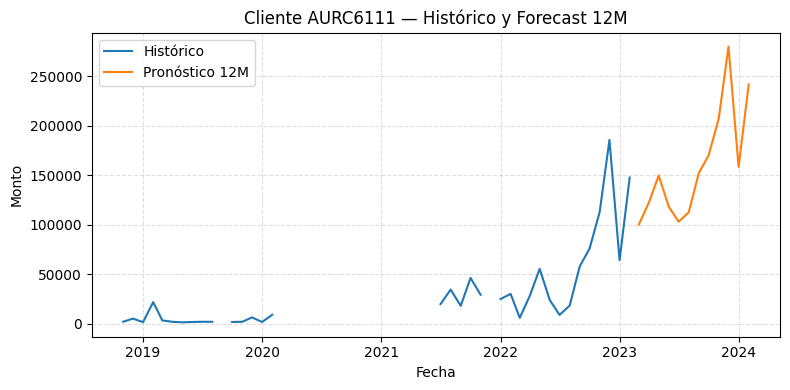

In [20]:

# Se toma cualquier user
cid_demo = df_ventas['user'].iloc[3102]
hist_cli = df_ventas[df_ventas['user'] == cid_demo].set_index('mes')['monto'].asfreq('MS')
fut_cli = forecast[forecast['user'] == cid_demo].set_index('mes')['yhat']

plt.figure(figsize=(8,4))
plt.plot(hist_cli.index, hist_cli.values, label='Histórico')
plt.plot(fut_cli.index, fut_cli.values, label='Pronóstico 12M')
plt.title(f'Cliente {cid_demo} — Histórico y Forecast 12M')
plt.xlabel('Fecha'); plt.ylabel('Monto')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
